# MentalAI

Author: Andreas Schmitt

Date: June/July 2020

## Overview

1. Preparation
2. Data cleaning
3. Preparation for training
4. The Model
5. Training
6. Prediction

In [1]:
VERSION = 17

## 1. Preparation

### Working directory

In [2]:
from os import getcwd
WD = getcwd()

### Libraries

In [3]:
# Working with CSV
import pandas as pd

# Math
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import GridSearchCV

# Deep learning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten, LSTM
   
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

### Seed

In [4]:
np.random.seed(42)

### Data

In [5]:
train_data = pd.read_csv(WD + "/Data/Train.csv")
test_data = pd.read_csv(WD + "/Data/Test.csv")
sample_submission = pd.read_csv(WD + "/Data/SampleSubmission.csv")

In [6]:
train_data.head()

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression


In [7]:
test_data.head()

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?


In [8]:
sample_submission.head()

,ID,Depression,Alcohol,Suicide,Drugs
0,02V56KMO,0,0,0,0
1,03BMGTOK,0,0,0,0
2,03LZVFM6,0,0,0,0
3,0EPULUM5,0,0,0,0
4,0GM4C5GD,0,0,0,0


## 2. Data cleaning

In [9]:
def clean_texts(data):
    # introduce whitespace before uppercase
    data.text = data.text.str.replace(r'(\w)([A-Z])', r'\1 \2', regex=True)
    
    # replace 've
    data.text = data.text.str.replace(r"(\w)\'ve", r'\1 have', regex=True)
    
    # replace 's
    data.text = data.text.str.replace(r"(\w)\'s", r'\1 is', regex=True)
    
    # replace 'm
    data.text = data.text.str.replace(r"(\w)\'m", r'\1 am', regex=True)
    
    # replace can't
    data.text = data.text.str.replace(r"can't", r"cannot", regex=True)
    
    # replace n't
    data.text = data.text.str.replace(r"(\w)n\'t", r'\1 not', regex=True)
                                      
    # remove signs
    data.text = data.text.str.replace(r'\W', ' ', regex=True)
        
    # lowercase
    data.text = data.text.str.lower() 
    
    # remove single characters
    data.text = data.text.str.replace(r"\s+[a-z]\s+", ' ', regex=True)
    data.text = data.text.str.replace(r"^[a-z]\s+", ' ', regex=True)
    
    # remove unnecessary whitespace
    data.text = data.text.str.replace('\s+', ' ', regex=True)

    # remove left and right whitespace
    data.text = data.text.str.strip('\n \t')    
    
    return data

train_data = clean_texts(train_data)
test_data = clean_texts(test_data)

train_data.head()

,ID,text,label
0,SUAVK39Z,feel that it was better die am happy,Depression
1,9JDAGUV3,why do get hallucinations,Drugs
2,419WR1LQ,am stresseed due to lack of financial support ...,Depression
3,6UY7DX6Q,why is life important,Suicide
4,FYC0FTFB,how could be helped to go through the depression,Depression


## 3. Preparation for training

### One-hot encoding of label

In [10]:
one_hot_encodings = pd.get_dummies(train_data.label)
train_data = train_data.drop(['ID', 'label'], axis=1)
train_data = train_data.join(one_hot_encodings)
train_data = train_data[['text', 'Depression', 'Alcohol', 'Suicide', 'Drugs']]
train_data.head()

,text,Depression,Alcohol,Suicide,Drugs
0,feel that it was better die am happy,1,0,0,0
1,why do get hallucinations,0,0,0,1
2,am stresseed due to lack of financial support ...,1,0,0,0
3,why is life important,0,0,1,0
4,how could be helped to go through the depression,1,0,0,0


### Frequencies

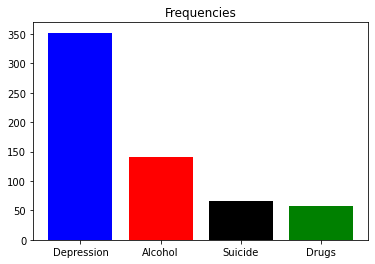

In [11]:
frequencies = [sum(train_data.Depression), sum(train_data.Alcohol), sum(train_data.Suicide), sum(train_data.Drugs)]

x_axis = ['Depression', 'Alcohol', 'Suicide', 'Drugs']

plt.bar(x_axis, frequencies, color=['blue', 'red', 'black', 'green'])
plt.title('Frequencies')
plt.show()

### Tokenization and vectorization

In [12]:
num_words = 0

for t in train_data.text:
    num_words += len(t.split())

for t in test_data.text:
    num_words += len(t.split())

print("num_words: %i" % num_words)

tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(train_data.text)

train_vectors = tokenizer.texts_to_sequences(train_data.text)
test_vectors = tokenizer.texts_to_sequences(test_data.text)

num_words: 6566


### Training data X and targets y

In [13]:
X = train_vectors

vocabular_size = len(tokenizer.word_index) + 1
print("vocabular_size: %i" % vocabular_size)

maxlen = np.max([np.max([len(i) for i in train_vectors]), np.max([len(i) for i in test_vectors])])
print("maxlen: %i" % maxlen)

X = pad_sequences(X, padding='post', maxlen=maxlen)
test_vectors = pad_sequences(test_vectors, padding='post', maxlen=maxlen)

y = np.array(train_data[['Depression', 'Alcohol', 'Suicide', 'Drugs']])
print("Shape of X: ", X.shape, "\nShape of y: ", y.shape)

vocabular_size: 826
maxlen: 33
Shape of X:  (616, 33) 
Shape of y:  (616, 4)


### Embedding matrix

In [14]:
embedding_dimension = 100
embedding_matrix = np.zeros((vocabular_size, embedding_dimension))
with open(WD + '/glove.6B/glove.6B.100d.txt') as file:
    for line in file:
        word, *vector = line.split()
        if word in tokenizer.word_index:
            embedding_matrix[tokenizer.word_index[word]] = np.array(vector)[:embedding_dimension]

coverage = round(np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1)) / vocabular_size, 2)

print("Coverage: {0:.0%}".format(coverage))

Coverage: 95%


## 4. The Model

In [15]:
def get_model(lstm, dense1, dense2, dropout_lstm, dropout_dense):

    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(vocabular_size, embedding_dimension, weights=[embedding_matrix], trainable=False,
                        input_length=maxlen))            

    # Recurrent layer with LSTM cells
    model.add(LSTM(lstm, dropout=dropout_lstm, recurrent_dropout=dropout_lstm, return_sequences=True))
        
    model.add(Flatten())
            
    # Dense layers
    model.add(Dense(dense1, activation='tanh')) 
    model.add(Dropout(dropout_dense))
    model.add(Dense(dense2, activation='tanh'))
       
    # Output
    model.add(Dense(4, activation='softmax'))
    
    # Model run
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))

    return model

## 5. Training

### Model

In [16]:
model = get_model(100, 10, 10, 0.0, 0.0)
model.summary()

2020-07-05 14:33:43.095154: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-07-05 14:33:43.095223: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-07-05 14:33:43.095271: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Librem13): /proc/driver/nvidia/version does not exist
2020-07-05 14:33:43.095903: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-07-05 14:33:43.142445: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2899885000 Hz
2020-07-05 14:33:43.143305: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2ff0000b60 initialized for platform Host (this does not guarantee that X

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 100)           82600     
_________________________________________________________________
lstm (LSTM)                  (None, 33, 100)           80400     
_________________________________________________________________
flatten (Flatten)            (None, 3300)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                33010     
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 4

### Grid search

In [17]:
def grid_search(model, grid):

    gs = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=3, scoring='neg_log_loss')
    gs_fit = gs.fit(X, y)

    print("Best: {}".format(round(-1 * gs_fit.best_score_, 2)))
    print("Best parameters: %s\n" % gs_fit.best_params_)

    means = gs_fit.cv_results_['mean_test_score']
    stds = gs_fit.cv_results_['std_test_score']
    parameter = gs_fit.cv_results_['params']
    
    i = 1
    for mean, stdev, param in zip(means, stds, parameter):
        print(str(i) + ". {}".format(round(-1 * mean, 2)) + " +-{}".format(round(stdev, 2)))
        print("parameters: %s\n" % param)      
        i += 1
     
    return gs_fit

#### Experiment

In [18]:
model = KerasClassifier(build_fn=get_model, batch_size=5, verbose=0)

parameter_grid = dict(epochs=[15],
                      lstm=[100, 250],
                      dense1=[10, 20],
                      dense2=[5],
                      dropout_lstm=[0.3, 0.4],
                      dropout_dense=[0.3, 0.4])                   
                    
grid_search_result = grid_search(model, parameter_grid)

2020-07-05 14:33:47.515054: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-07-05 14:33:47.515090: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-07-05 14:33:47.515117: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Librem13): /proc/driver/nvidia/version does not exist
2020-07-05 14:33:47.515351: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-07-05 14:33:47.542144: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2899885000 Hz
2020-07-05 14:33:47.542687: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6714000b60 initialized for platform Host (this does not guarantee that X

Best: 0.51
Best parameters: {'dense1': 10, 'dense2': 5, 'dropout_dense': 0.4, 'dropout_lstm': 0.4, 'epochs': 15, 'lstm': 100}

1. 0.55 +-0.02
parameters: {'dense1': 10, 'dense2': 5, 'dropout_dense': 0.3, 'dropout_lstm': 0.3, 'epochs': 15, 'lstm': 100}

2. 0.74 +-0.32
parameters: {'dense1': 10, 'dense2': 5, 'dropout_dense': 0.3, 'dropout_lstm': 0.3, 'epochs': 15, 'lstm': 250}

3. 0.54 +-0.03
parameters: {'dense1': 10, 'dense2': 5, 'dropout_dense': 0.3, 'dropout_lstm': 0.4, 'epochs': 15, 'lstm': 100}

4. 0.53 +-0.05
parameters: {'dense1': 10, 'dense2': 5, 'dropout_dense': 0.3, 'dropout_lstm': 0.4, 'epochs': 15, 'lstm': 250}

5. 0.57 +-0.07
parameters: {'dense1': 10, 'dense2': 5, 'dropout_dense': 0.4, 'dropout_lstm': 0.3, 'epochs': 15, 'lstm': 100}

6. 0.53 +-0.07
parameters: {'dense1': 10, 'dense2': 5, 'dropout_dense': 0.4, 'dropout_lstm': 0.3, 'epochs': 15, 'lstm': 250}

7. 0.51 +-0.02
parameters: {'dense1': 10, 'dense2': 5, 'dropout_dense': 0.4, 'dropout_lstm': 0.4, 'epochs': 15, 'lstm

### Best model

Epoch 1/15
99/99 [==============================] - 4s 36ms/step - loss: 1.0604 - val_loss: 0.8894
Epoch 2/15
99/99 [==============================] - 7s 74ms/step - loss: 0.9035 - val_loss: 0.7476
Epoch 3/15
99/99 [==============================] - 4s 41ms/step - loss: 0.7258 - val_loss: 0.6821
Epoch 4/15
99/99 [==============================] - 4s 41ms/step - loss: 0.6062 - val_loss: 0.5580
Epoch 5/15
99/99 [==============================] - 4s 40ms/step - loss: 0.5935 - val_loss: 0.5911
Epoch 6/15
99/99 [==============================] - 4s 41ms/step - loss: 0.5200 - val_loss: 0.5685
Epoch 7/15
99/99 [==============================] - 4s 42ms/step - loss: 0.4973 - val_loss: 0.5324
Epoch 8/15
99/99 [==============================] - 4s 41ms/step - loss: 0.4387 - val_loss: 0.5431
Epoch 9/15
99/99 [==============================] - 4s 43ms/step - loss: 0.4284 - val_loss: 0.5679
Epoch 10/15
99/99 [==============================] - 4s 37ms/step - loss: 0.3863 - val_loss: 0.5173
Epoch 11/

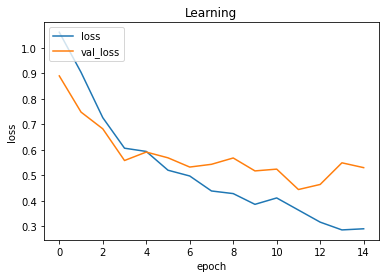

In [22]:
model = get_model(100, 10, 5, 0.4, 0.4)

modelcheckpoint = ModelCheckpoint(
    filepath=WD + '/Submission/' + str(VERSION) + '/checkpoint_model.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model_fit = model.fit(X, y, batch_size=5, epochs=15, verbose=True, validation_split=0.2,
                      callbacks=[modelcheckpoint])

model.load_weights(WD + '/Submission/' + str(VERSION) + '/checkpoint_model.h5')

plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Learning')
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','val_loss'], loc='upper left')
plt.show()

## 6. Prediction

In [23]:
prediction = model.predict(test_vectors)

### Output frequencies

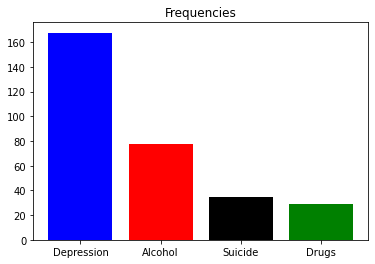

In [24]:
frequencies = [sum(prediction[:, 0]), sum(prediction[:, 1]), sum(prediction[:, 2]), sum(prediction[:, 3])]

x_axis = ['Depression', 'Alcohol', 'Suicide', 'Drugs']

plt.bar(x_axis, frequencies, color=['blue', 'red', 'black', 'green'])
plt.title('Frequencies')
plt.show()

### Saving

In [25]:
model.save(WD + '/Submission/' + str(VERSION) + '/model.h5')

output = pd.DataFrame({'ID': sample_submission.ID, 
                       'Depression': prediction[:, 0],
                       'Alcohol': prediction[:, 1],
                       'Suicide': prediction[:, 2],
                       'Drugs': prediction[:, 3]})

output.to_csv(WD + '/Submission/' + str(VERSION) + '/submission.csv', index=False)
print("Done.")

Done.
